In [1]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


In [3]:
import zipfile
import os

# Extract the zip file
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("Animals")

# Check contents
os.listdir("Animals")

['README.md', 'Animals']

In [5]:
import shutil
from sklearn.model_selection import train_test_split

def prepare_split(source_dir, base_dir='Animals_split', split_ratio=0.2):
    os.makedirs(base_dir, exist_ok=True)

    # Assuming the actual image directories are within a nested directory named 'Animals'
    nested_source_dir = os.path.join(source_dir, 'Animals')

    for category in os.listdir(nested_source_dir):
        category_path = os.path.join(nested_source_dir, category)
        if not os.path.isdir(category_path):
            # Skip files like README.md
            continue

        images = os.listdir(category_path)
        train_imgs, val_imgs = train_test_split(images, test_size=split_ratio, random_state=42)

        for folder in ['train', 'val']:
            os.makedirs(os.path.join(base_dir, folder, category), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(base_dir, 'train', category, img))

        for img in val_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(base_dir, 'val', category, img))

prepare_split("Animals")

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [7]:
train_dir = 'Animals_split/train'
val_dir = 'Animals_split/val'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 2400 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the pre-trained layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # Changed from 3 to 4 classes
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
# STEP 7: Improved training with data augmentation and fine-tuning

# 🔸 Step 7.1: Enable Data Augmentation
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 🔸 Step 7.2: Unfreeze the top layers of ResNet50 for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onward
fine_tune_at = 140

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 🔸 Step 7.3: Add EarlyStopping (optional) and Train for more epochs
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

history = model.fit(
    train_generator_aug,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


Found 2400 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 518ms/step - accuracy: 0.4626 - loss: 1.3600 - val_accuracy: 0.4700 - val_loss: 1.0108 - learning_rate: 1.0000e-05
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 451ms/step - accuracy: 0.6151 - loss: 0.8078 - val_accuracy: 0.3867 - val_loss: 1.0595 - learning_rate: 1.0000e-05
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 438ms/step - accuracy: 0.6376 - loss: 0.7586 - val_accuracy: 0.5000 - val_loss: 0.9141 - learning_rate: 1.0000e-05
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 459ms/step - accuracy: 0.6554 - loss: 0.7375 - val_accuracy: 0.6933 - val_loss: 0.7031 - learning_rate: 1.0000e-05
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 460ms/step - accuracy: 0.6718 - loss: 0.6893 - val_accuracy: 0.6717 - val_loss: 0.7170 - learning_rate: 1.0000e-05
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 447ms/step - accuracy: 0.6995 - loss: 0.6682 - val_accuracy: 0.7233 - val_loss: 0.6218 - learning_rate: 1.0000e-05
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 435ms/step - acc

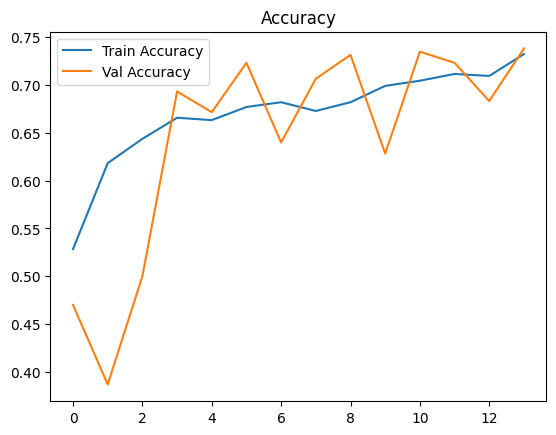

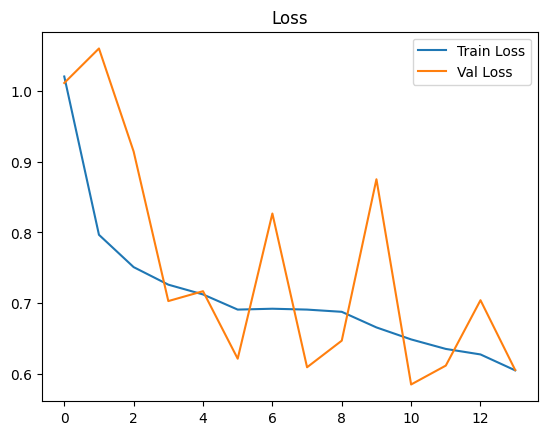

In [13]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [14]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc*100:.2f}%")

model.save("animal_classifier_resnet50.h5")


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7398 - loss: 0.5724


Validation Accuracy: 73.50%
